In [1]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp

from functools import partial

jax.config.update('jax_enable_x64', True)

In [2]:
import math
import numpy as np
import plotly.express as px
import IPython
import matplotlib.pyplot as plt 
import ipywidgets as widgets

%config InlineBackend.figure_formats = ['svg']

In [3]:
from jax_control_algorithms.trajectory_optimization import Functions, SolverSettings, ProblemDefinition, constraint_geq, constraint_leq, unpack_res, generate_penalty_parameter_trace

In [4]:
test_results = []

# Optimal spending of stored electricity in a battery

In [5]:
def problem_def(n_steps):
        
    def model(x, u, k, parameters):
        x_1 = x[0] # state of charge 0 to 1
        u_1 = u[0] # normalized discharge power

        capacity = parameters['capacity']
        max_discharge_power = parameters['max_discharge_power']
        dt = parameters['dt'][k]
        price = parameters['price'][k]
        
        discharge_power = u_1 * max_discharge_power
        
        x_1_next = x_1 + dt * 1/capacity * (-discharge_power)
        
        x_next = jnp.array([
            x_1_next,
        ])
        
        # cost function
        J =  -price * dt * u_1
        
        outputs = {
            'charge' : capacity * x_1,
            'charge_next' : capacity * x_1_next,
            'discharge_power' : discharge_power,
            'price': price,
            'dt': dt,
        }
        
        return x_next, J, outputs

    def f(x, u, k, parameters):
        x_next, _, _ = model(x, u, k, parameters)
        return x_next

    def g(x, u, k, parameters):
        x_next, _, outputs = model(x, u, k, parameters)
        return outputs
    
    def running_cost(x, u, k, parameters):
        _t, J, _ = model(x, u, k, parameters)
        J_normalized = J * 1.0 / n_steps
        
        return J_normalized
        
    def inequality_constraints(X, U, K, parameters):
        
        U_1 = U[:,0]
        X_1 = X[:,0]
        
        # constraints
        c_ineq = jnp.array([
            constraint_geq( U_1, 0.0 ),
            constraint_leq( U_1, 1.0 ),
            
            constraint_geq( X_1, 0.0 ),
            constraint_leq( X_1, 1.0 ),
        ])
        
        return c_ineq

    def initial_guess(x0, parameters):
                
        U_guess = 0.1*jnp.ones( (n_steps, 1) )
        
        target = 0.001 # > 0
        X_guess = jnp.vstack((
            jnp.linspace( x0[0], target, n_steps),
        )).T
        
        return { 'X_guess' : X_guess, 'U_guess' : U_guess }
    
    assert n_steps % 2 == 0
    
    # default parameters
    parameters = {
        'capacity'            : 10.0,
        'max_discharge_power' : 1.8,
        'price'               : jnp.concatenate((
            jnp.linspace(0.6, 0.0, int(n_steps/2)),
            jnp.linspace(0.0, 1.5, int(n_steps/2)),
        )),
        'dt': jnp.full(n_steps, 1.0), # period length
    }
    
    x_1_init = 0.999 # < 1
    
    x0 = jnp.array([ x_1_init, ])

    return ProblemDefinition(
        functions = Functions(
            f                      = f,
            initial_guess          = initial_guess,
            g                      = g,
            running_cost           = running_cost,
            inequality_constraints = inequality_constraints,
        ),
        x0 = x0,
        parameters = parameters,
    )


def transform_system_outputs(system_outputs):
    system_outputs['charge'] = jnp.concatenate(( system_outputs['charge'], jnp.array([ system_outputs['charge_next'][-1] ]) ))
    system_outputs['discharge_power'] = jnp.concatenate(( system_outputs['discharge_power'], jnp.array([jnp.nan]) ))
    system_outputs['price'] = jnp.concatenate(( system_outputs['price'], jnp.array([jnp.nan]) ))
    system_outputs['time'] = jnp.concatenate(( jnp.array([0]), jnp.cumsum(system_outputs['dt']) ))
    
    return system_outputs

@jit
def solve(capacity : jnp.ndarray, initial_charge : jnp.ndarray):
    
    problem = problem_def(n_steps = 10)
    
    problem.parameters['capacity'] = capacity
    problem.x0 = jnp.array([ initial_charge / capacity, ])

    X, U_opt, system_outputs, res = problem.run(
        parameters=problem.parameters,
        verbose=True,
        solver_settings=SolverSettings(
            penalty_parameter_trace=generate_penalty_parameter_trace(t_final=1000000, n_steps=5),
        )
    )

    system_outputs = transform_system_outputs(system_outputs)

    return system_outputs

In [6]:
system_outputs = solve(10, 9.99)

compiling optimizer...
👉 solving problem with n_horizon=10, n_states=1 n_inputs=1
🔄 it=0 	 (sub iter=18)	t=0 	eq_error/eq_tol=18797  gain=0.0 lambda=2.8498322452538876 	inside bounds: True
🔄 it=1 	 (sub iter=44)	t=19 	eq_error/eq_tol=3548  gain=5.298233409248035 lambda=2.440570448979899 	inside bounds: True
🔄 it=2 	 (sub iter=105)	t=707 	eq_error/eq_tol=1496  gain=2.3712207305985573 lambda=2.440570448979899 	inside bounds: True
🔄 it=3 	 (sub iter=138)	t=26591 	eq_error/eq_tol=614  gain=2.4381815682402195 lambda=2.440570448979899 	inside bounds: True
🔄 it=4 	 (sub iter=80)	t=1000000 	eq_error/eq_tol=251  gain=2.4405675267041778 lambda=2.440570448979899 	inside bounds: True
🔄 it=5 	 (sub iter=153)	t=1000000 	eq_error/eq_tol=103  gain=2.440576901270966 lambda=2.440570448979899 	inside bounds: True
🔄 it=6 	 (sub iter=74)	t=1000000 	eq_error/eq_tol=42  gain=2.4405435002973723 lambda=2.440570448979899 	inside bounds: True
✅ found feasible solution


In [7]:
def plot(system_outputs):
    fig, (ax1, ax2, ax3, ) = plt.subplots(3, 1, sharex=True, figsize=(4, 6))

    time = system_outputs['time']
    
    ax1.plot(time, system_outputs['charge'], 'k', label='battery charge')
    ax1.plot(time, system_outputs['charge'], 'r+')
    ax1.legend()
    ax1.set_ylabel('charge [kWh]')

    ax2.step(time, system_outputs['discharge_power'], 'k', label='discharge power', where='post')
    ax2.plot(time, system_outputs['discharge_power'], 'r+')
    ax2.legend()
    ax2.set_ylabel('power [kW]')

    ax3.step(time, system_outputs['price'], 'k', label='electricity price', where='post')
    ax3.legend()
    ax3.set_ylabel('price [cent]')
    ax3.set_xlabel('time [hours]')
    ax3.grid()

compiling optimizer...
👉 solving problem with n_horizon=10, n_states=1 n_inputs=1
🔄 it=0 	 (sub iter=18)	t=0 	eq_error/eq_tol=23065  gain=0.0 lambda=2.96885497459227 	inside bounds: True
🔄 it=1 	 (sub iter=43)	t=19 	eq_error/eq_tol=4266  gain=5.406617527242973 lambda=2.5556702479580284 	inside bounds: True
🔄 it=2 	 (sub iter=96)	t=707 	eq_error/eq_tol=1648  gain=2.5893195604266754 lambda=2.5556702479580284 	inside bounds: True
🔄 it=3 	 (sub iter=66)	t=26591 	eq_error/eq_tol=645  gain=2.5557267984646015 lambda=2.5556702479580284 	inside bounds: True
🔄 it=4 	 (sub iter=80)	t=1000000 	eq_error/eq_tol=252  gain=2.55571363693431 lambda=2.5556702479580284 	inside bounds: True
🔄 it=5 	 (sub iter=172)	t=1000000 	eq_error/eq_tol=99  gain=2.5556649409288155 lambda=2.5556702479580284 	inside bounds: True
✅ found feasible solution


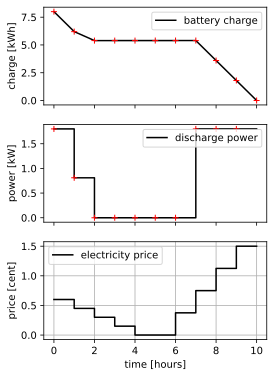

In [8]:
plot(solve(10, 8))

# Verify

In [10]:
def verify_test_results(test_results):
    for r in test_results:
        if not r[1]:
            raise BaseException('Test ' + r[0] + ' failed')
            
verify_test_results(test_results)